# Google maps distances

In [1]:
import utils
import numpy as np
import googlemaps
import time

api_key = open("googlemaps-apikey.txt", "r").read()
client = googlemaps.Client(key=api_key)

In [14]:
import importlib
importlib.reload(utils)

<module 'utils' from '/mnt/h/Documents/fifth_year_shit/math441/project/utils.py'>

Only take points that have addresses

84


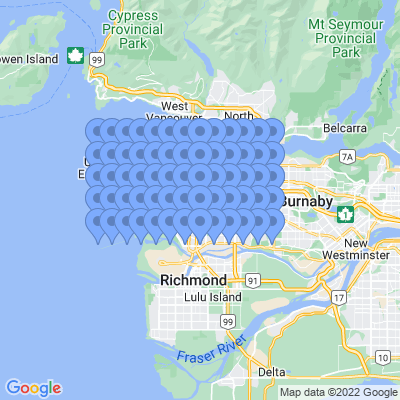

KeyboardInterrupt: 

In [16]:
test_problem_center = (49.249828, -123.125774)
test_problem_top_left = (49.295863, -123.270310)
test_problem_bottom_right = (49.196127, -123.021401)
test_problem_points = utils.equidistant_points(test_problem_center, test_problem_top_left, test_problem_bottom_right, height=6, width=20, unit=0.02)
print(len(test_problem_points))
display(utils.get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))
test_problem_points = list(filter(lambda p: utils.has_address_in(p, city="Vancouver"), test_problem_points))
print(len(test_problem_points))
display(utils.get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))

Define set covering based on the real world google maps travel time

In [5]:
def make_set_covering_problem(positions):
    positions = [str(lat) + "," + str(long) for lat,long in positions]
    elems_per_min = 1000
    req_per_min = elems_per_min // len(positions)
    sleep_amt = int(60/req_per_min)
    print(f"Creating set covering matrix (n = {len(positions)}) (ratelimit sleep = {sleep_amt}s)")
    covering_matrix = np.array([])
    for start in positions:
        time.sleep(sleep_amt)
        # we can only have at most 25 destination, so we have to do this
        covered = []
        for slice_start_idx in range(0, len(positions), 25):
            # print(f"slice {slice_start_idx}, {slice_start_idx + 25}")
            # TODO: the covering matrix is symmetric, we can do half the number of elements requested from the api...
            destinations_slice = positions[slice_start_idx: slice_start_idx + 25]
            matrix = client.distance_matrix(origins=start, destinations=destinations_slice)
            times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]][0]
            covered.extend([1 if t < utils.NINE_MINS else 0 for t in times])
        assert(len(covered) == len(positions))
        covering_matrix = np.hstack((covering_matrix, covered))
    return covering_matrix.reshape(len(positions), len(positions))

    # the api restricts me to 100 elements per request, so this would fail on anything with more than 10 points
    # rip
    # matrix = client.distance_matrix(origins=positions, destinations=positions)
    # times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]]
    # covering_matrix = np.array([[1 if t < NINE_MINS else 0 for t in row] for row in times])
    # return covering_matrix.reshape(len(positions), len(positions))

In [6]:
solution = utils.linprog_solver(test_problem_points, make_set_covering_problem(test_problem_points))

Creating set covering matrix (n = 57) (ratelimit sleep = 3s)


In [7]:
print(f"Locations used: {len(solution)}")

Locations used: 7


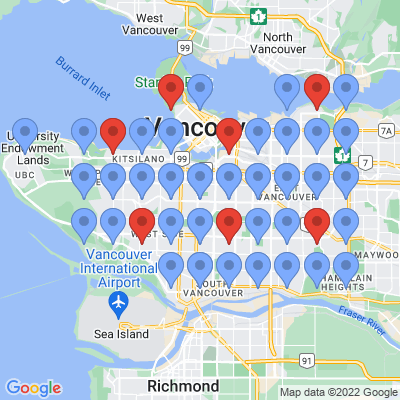

In [12]:
utils.display_solution(test_problem_center, test_problem_points, solution, show_coverage=False)

In [15]:
utils.display_solution(test_problem_center, test_problem_points, solution, show_coverage=True)

ApiError: INVALID_REQUEST